# IMAGE ANALYSIS

In [1]:
import os
import sys
import torch
import random
import tifffile
import numpy as np
import matplotlib.pyplot as plt


# Get the parent directory (project root) and add it to sys.path
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_dir not in sys.path:
    sys.path.append(root_dir)


from utils.utils import standardize_tensor, compute_global_mean_std, tonemap_gamma_correct
from renderer.SceneRenderer import SceneRenderer

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


# STANDARDISATION ONLY
- Global: Stable but ignores image-specific details.
- Per image: Captures individual contrast but loses global info.
- Per patch: Handles local variation but may cause inconsistency.
- Per batch: best one yet !!!

*NOTE:* still issue with very high dynamic ranges HDR!

In [ ]:
root_dir = "../output/"  # <- set your root path here

mean, std = compute_global_mean_std(root_dir)

print("Global Statistics (Box-Cox Transformed)")
print(f"Mean: {[round(x.item(), 4) for x in mean.view(-1)]}")
print(f"Std : {[round(x.item(), 4) for x in std.view(-1)]}")

# LOG NORMALISATION + STANDARDISATION

# Box-Cox Transform and Standardization

The **Box-Cox transform** stabilizes variance and makes data more Gaussian-like:

$$
y(\lambda) = 
\begin{cases}
\dfrac{x^\lambda - 1}{\lambda} & \lambda \neq 0 \\
\log(x) & \lambda = 0
\end{cases}
$$

where $x > 0$ and $\lambda$ controls the transformation shape.

After that, **standardization** normalizes data to zero mean and unit variance:

$$
z = \dfrac{y - \mu}{\sigma}
$$

with $\mu$ and $\sigma$ being the mean and std of $y$.

These can be reverted to get back the original image.

In [ ]:
def process_and_print_stats(images, title):
    print(f"\n {title} statistics:")
    for name, img in images.items():
        img_tensor = img if isinstance(img, torch.Tensor) else torch.from_numpy(img).permute(2, 0, 1).float()
        print(f"Image {name}:")
        for c, channel_name in enumerate(["R", "G", "B"]):
            channel = img_tensor[c]
            ch_min = channel.min().item()
            ch_max = channel.max().item()
            ch_mean = channel.mean().item()
            ch_std = channel.std().item()
            print(f"{channel_name}: min={ch_min:.4f}, max={ch_max:.4f}, "
                  f"mean={ch_mean:.4f}, std={ch_std:.4f}")

def plot_set(images, scene_name, stage):
    plt.figure(figsize=(16, 4))
    for i, (name, img) in enumerate(images.items()):
        img_disp = img.permute(1, 2, 0).cpu().numpy() if isinstance(img, torch.Tensor) else img
        img_disp = np.clip(img_disp, 0, 1)
        plt.subplot(1, len(images), i+1)
        plt.imshow(img_disp)
        plt.title(name)
        plt.axis("off")
    plt.suptitle(f"{scene_name} - {stage}", fontsize=14)
    plt.tight_layout()
    plt.show()

def process_scene_boxcox_std(folder_path, lmbda=0.2):
    scene_name = os.path.basename(folder_path)
    files = os.listdir(folder_path)

    # Get file paths
    path_4500 = next((f for f in files if "spp4500" in f), None)
    path_32   = next((f for f in files if "spp32.tiff" in f and "1x32" not in f), None)
    path_1x32 = next((f for f in files if "spp1x32" in f), None)

    if not all([path_4500, path_32, path_1x32]):
        print(f"Missing files in {scene_name}, skipping...")
        return

    # Load images
    img_clean = tifffile.imread(os.path.join(folder_path, path_4500)).astype(np.float32)
    img_noisy = tifffile.imread(os.path.join(folder_path, path_32)).astype(np.float32)
    img_1spp_stack = tifffile.imread(os.path.join(folder_path, path_1x32)).astype(np.float32)  # (N, H, W, C)

    # Random sample and mean image
    random_sample = img_1spp_stack[random.randint(0, img_1spp_stack.shape[0] - 1)]
    mean_1spp = np.mean(img_1spp_stack, axis=0)

    # Convert all to tensors and permute to (C, H, W)
    base_images = {
        "1spp sample": torch.from_numpy(random_sample).permute(2, 0, 1).float(),
        "mean 1spp": torch.from_numpy(mean_1spp).permute(2, 0, 1).float(),
        "32 spp": torch.from_numpy(img_noisy).permute(2, 0, 1).float(),
        "4500 spp (clean)": torch.from_numpy(img_clean).permute(2, 0, 1).float()
    }

    # Step 1: Original stats and plot
    process_and_print_stats(base_images, "Original")
    plot_set(base_images, scene_name, "Original")

    # Step 2: Box-Cox transform
    boxcox_images = {k: boxcox_transform(v.clone(), lmbda=lmbda) for k, v in base_images.items()}
    process_and_print_stats(boxcox_images, f"Box-Cox (λ={lmbda})")
    plot_set(boxcox_images, scene_name, "Box-Cox Transform")

    # Step 3: Standardize Box-Cox images
    standardized_images = {}
    standardization_stats = {}  # store mean/std per image for inversion
    for k, v in boxcox_images.items():
        standardized, mean, std = standardize_tensor(v)  # per-image mean/std
        standardized_images[k] = standardized
        standardization_stats[k] = (mean, std)
    process_and_print_stats(standardized_images, "Standardized Box-Cox")
    plot_set(standardized_images, scene_name, "Standardized Box-Cox")

    # Step 4: Invert Standardization and Box-Cox transform
    recovered_images = {}
    for k, std_img in standardized_images.items():
        mean, std = standardization_stats[k]
        unstandardized = unstandardize_tensor(std_img, mean, std)
        recovered_images[k] = unstandardized
    process_and_print_stats(recovered_images, "Recovered Images (Inverse Box-Cox & Unstandardize)")
    plot_set(recovered_images, scene_name, "Recovered Images")

In [ ]:
scene_path = "../output/classroom/"
process_scene_boxcox_std(scene_path)

# Albedo Normalisation

Radiance (RGB) = Albedo * Shading ---> Shading = Radiance (RGB) / Albedo + eps

where: 
- **radiance** (RGB) = amount of light
- **albedo** = true color of a surface/how much light it reflects
- **shading** = how light/shadow fall ona surface

Albedo Normalisation is more consistent across different scenes but reverted image may be darker than the original one.

In [4]:
import os
import numpy as np
import mitsuba as mi
import matplotlib.pyplot as plt

def compute_channel_stats(img, name="Image"):
    """
    Computes and prints per-channel mean and std for a given image.
    Assumes img shape is (H, W, C)
    """
    print(f"\n{name} Statistics:")
    for i, color in enumerate(['R', 'G', 'B']):
        channel = img[..., i]
        print(f"  {color}: mean={channel.mean():.4f}, std={channel.std():.4f}")

def safe_divide(numerator, denominator, eps=1e-4):
    return numerator / np.clip(denominator, eps, None)

In [ ]:
def recover_scene_with_albedo(scene_folder, spp=16):
    mi.set_variant("llvm_ad_rgb")

    scene_path = os.path.join(scene_folder, "scene.xml")
    scene = mi.load_file(scene_path)

    # Define AOV integrator that includes albedo
    integrator = mi.load_dict({
        'type': 'aov',
        'aovs': 'aa:albedo',
        'my_image': {
            'type': 'path'
        }
    })

    # Render the full image (RGB + AOVs)
    img_full = mi.render(scene, spp=spp, integrator=integrator)
    img_full = np.array(img_full)

    # The output shape is (H, W, N_channels)
    _, _, C = img_full.shape

    if C < 6:
        raise RuntimeError(f"Expected at least 6 channels (RGB + albedo), got {C}.")

    # Split RGB and albedo
    img_rgb = img_full[..., 0:3]
    img_albedo = img_full[..., 3:6]

    # Clamp to avoid NaNs / divisions by zero
    # img_rgb = np.clip(img_rgb, 0, 1)
    # img_albedo = np.clip(img_albedo, 1e-4, 1.0)

    # Reconstruct shading: RGB = Albedo * Shading → Shading ≈ RGB / Albedo
    img_shading = safe_divide(img_rgb, img_albedo)
    # Recover radiance from shading and albedo
    img_recovered = img_shading * img_albedo

    # Statistics
    compute_channel_stats(img_rgb, "Rendered Radiance")
    compute_channel_stats(img_albedo, "Albedo")
    compute_channel_stats(img_shading, "Shading (Radiance / Albedo)")
    compute_channel_stats(img_recovered, "Recovered Radiance")

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(tonemap_gamma_correct(img_rgb))
    axes[0].set_title("Rendered Radiance (Path)")
    axes[1].imshow(img_albedo)
    axes[1].set_title("AOV: Albedo")
    axes[2].imshow(tonemap_gamma_correct(img_shading))
    axes[2].set_title("Approx. Shading (Radiance / Albedo)")
    axes[3].imshow(tonemap_gamma_correct(img_recovered))
    axes[3].set_title("Recovered Radiance (Shading * Albedo)")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


Rendered Radiance Statistics:
  R: mean=2.4407, std=10.5720
  G: mean=1.4346, std=6.1076
  B: mean=0.6218, std=2.3781

Albedo Statistics:
  R: mean=0.4503, std=0.3034
  G: mean=0.3934, std=0.3341
  B: mean=0.3658, std=0.3532

Shading (Radiance / Albedo) Statistics:
  R: mean=19155.4434, std=103342.6406
  G: mean=10920.6826, std=59663.8750
  B: mean=4336.4487, std=23244.9551

Recovered Radiance Statistics:
  R: mean=0.5255, std=2.6422
  G: mean=0.3428, std=1.5664
  B: mean=0.1886, std=0.6444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..33.995857].


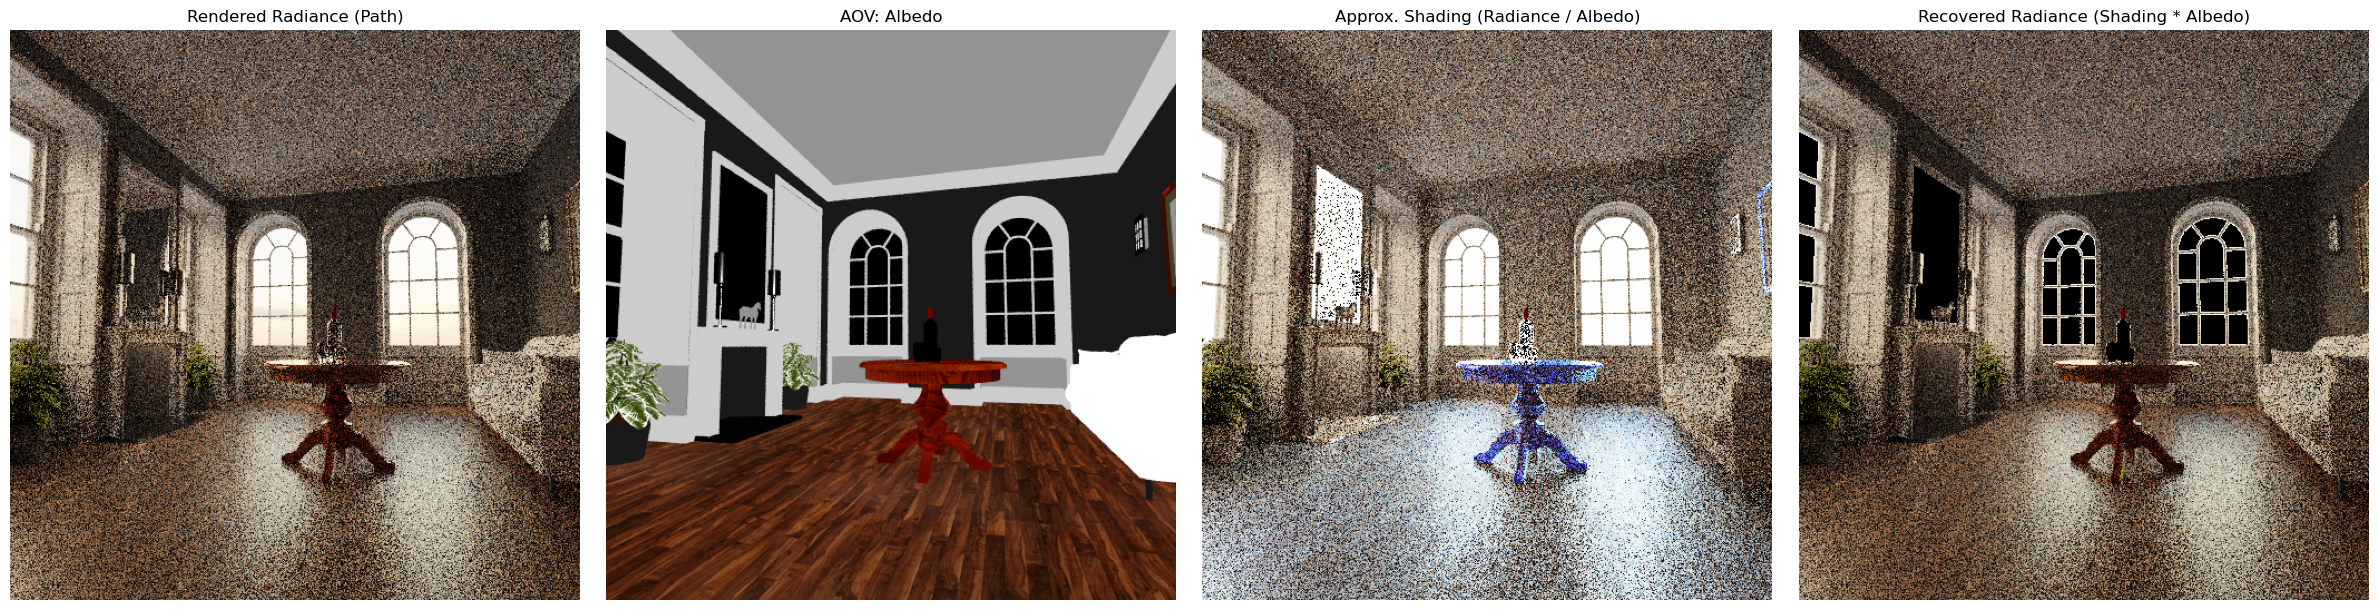

In [15]:
recover_scene_with_albedo("../data/living-room/", spp=16)

In [18]:
def render_scene_albedo_normal(scene_folder, spp=16):
    mi.set_variant("llvm_ad_rgb")

    scene_path = os.path.join(scene_folder, "scene.xml")
    scene = mi.load_file(scene_path)

    # Define AOV integrator that includes albedo
    integrator = mi.load_dict({
        'type': 'aov',
        'aovs': 'aa:albedo,nn:sh_normal',
        'my_image': {
            'type': 'path'
        }
    })

    # Render the full image (RGB + AOVs)
    img_full = mi.render(scene, spp=spp, integrator=integrator)
    img_full = np.array(img_full)

    # The output shape is (H, W, N_channels)
    _, _, C = img_full.shape

    if C < 6:
        raise RuntimeError(f"Expected at least 6 channels (RGB + albedo), got {C}.")

    # Split RGB and albedo
    img_rgb = img_full[..., 0:3]
    img_albedo = img_full[..., 3:6]
    img_normal = img_full[..., 6:9]

    print("Image Shape: ", img_rgb.shape)
    print("Albedo Shape: ", img_rgb.shape)
    print("Normal Shape: ", img_rgb.shape)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    axes[0].imshow(tonemap_gamma_correct(img_rgb))
    axes[0].set_title(f"Rendered Radiance (Path) - spp{spp}")
    axes[1].imshow(img_albedo)
    axes[1].set_title("AOV: Albedo")
    axes[2].imshow(img_normal)
    axes[2].set_title("AOV: Normal")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [7]:
def render_scene_aov(scene_folder, spp=16):
    scene_path = os.path.join(scene_folder, "scene.xml")
    renderer = SceneRenderer(scene_path, debug=False)

    # Split RGB and albedo
    img_albedo = renderer.render_albedo_image()
    img_normal = renderer.render_normal_image()

    print("Albedo Shape: ", img_albedo.shape)
    print("Normal Shape: ", img_normal.shape)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(24, 6))
    axes[0].imshow(img_albedo)
    axes[0].set_title("AOV: Albedo")
    axes[1].imshow(img_normal)
    axes[1].set_title("AOV: Normal")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


Using.. scalar_rgb (for albedo)
Using.. scalar_rgb (for normals)
Albedo Shape:  (512, 512, 3)
Normal Shape:  (512, 512, 3)


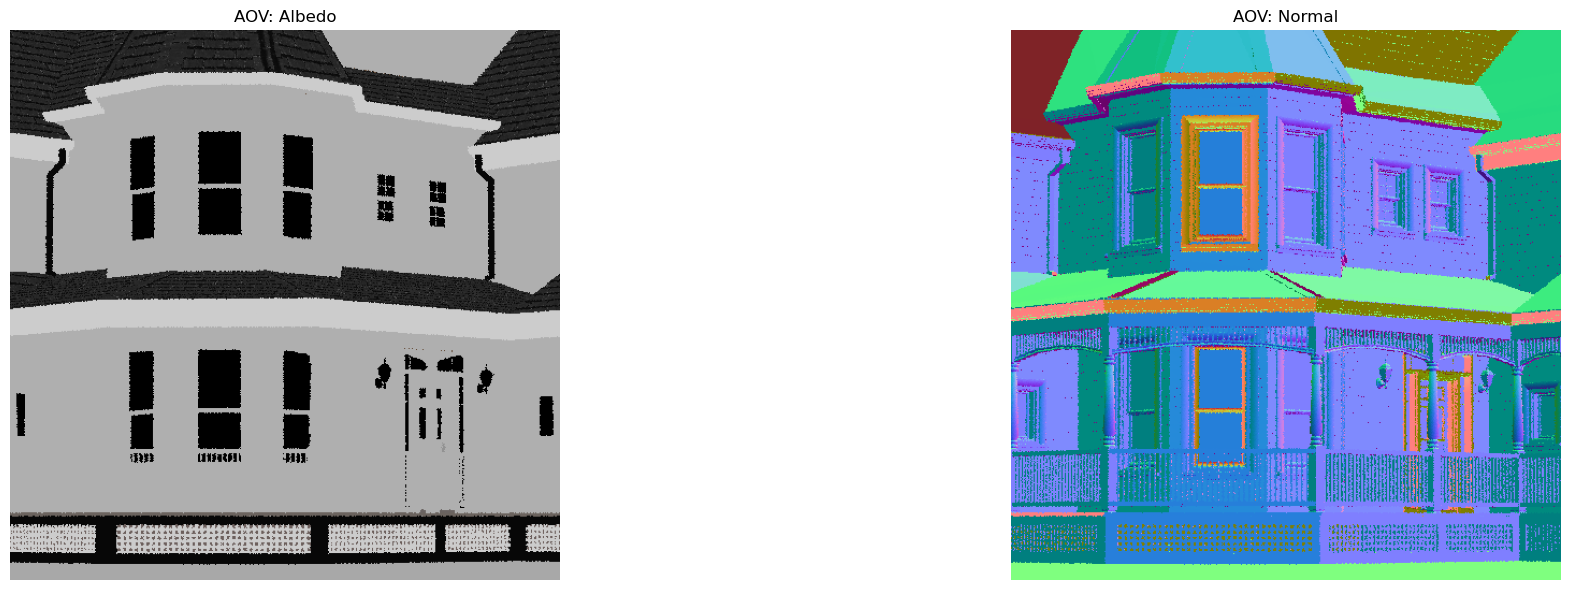

In [9]:
render_scene_aov("../data/house/", spp=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0000001].


Image Shape:  (512, 512, 3)
Albedo Shape:  (512, 512, 3)
Normal Shape:  (512, 512, 3)


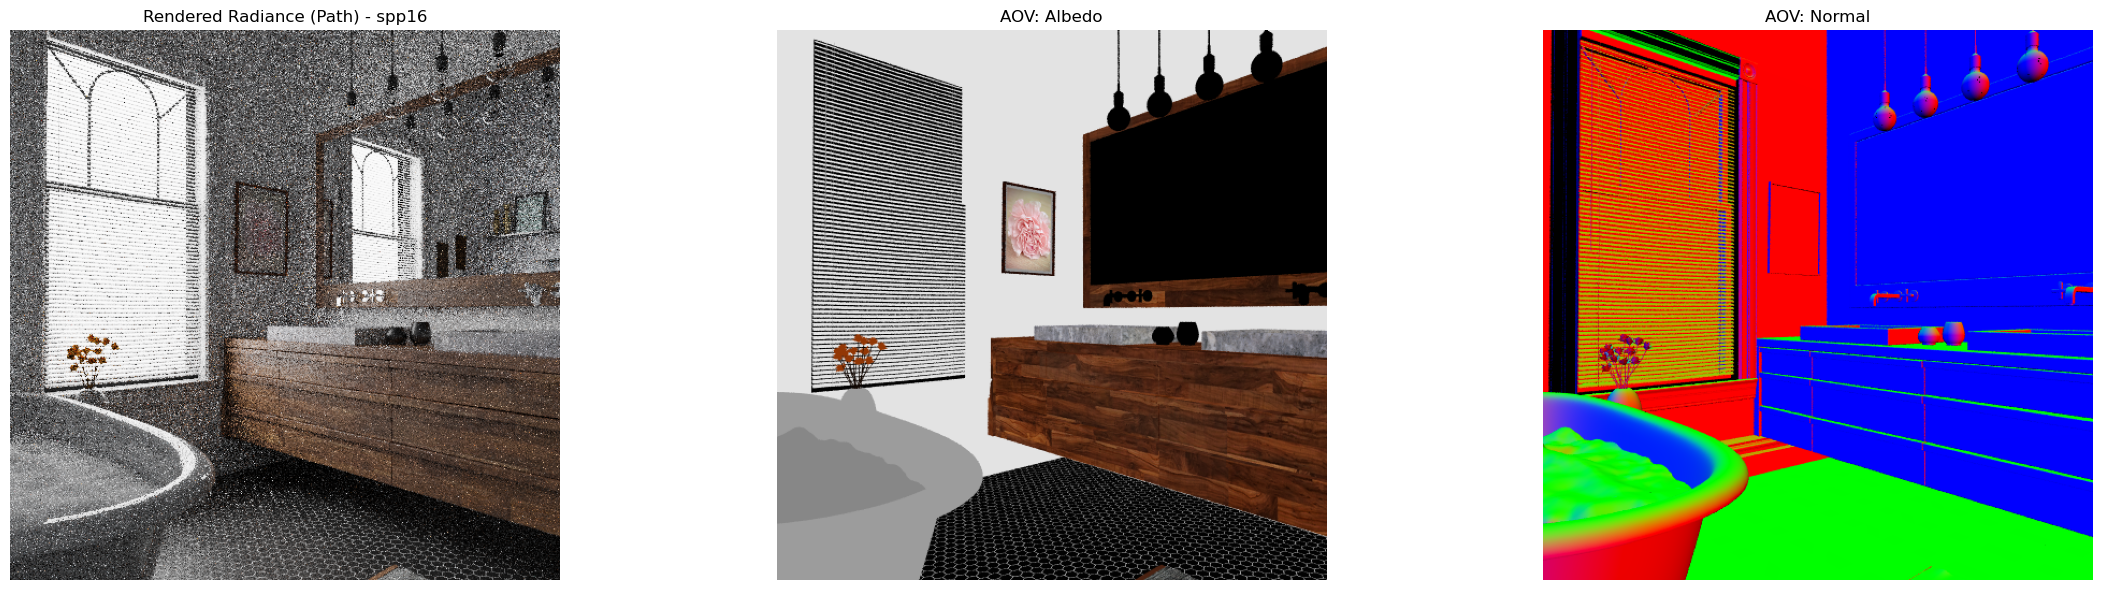

In [19]:
render_scene_albedo_normal("../data/bathroom/", spp=16)

# Utils Functions to Save Plots !!!

In [ ]:
import os
import math
import tifffile
import numpy as np
import matplotlib.pyplot as plt

def process_3scene(folder_path):
    scene_name = os.path.basename(folder_path)
    files = os.listdir(folder_path)

    path_4500 = next((f for f in files if "spp4500" in f), None)
    path_32   = next((f for f in files if "spp32.tiff" in f and "1x32" not in f), None)
    path_1x32 = next((f for f in files if "spp1x32" in f), None)

    if not all([path_4500, path_32, path_1x32]):
        print(f"Missing files in {scene_name}, skipping...")
        return None

    # Load raw images
    img_clean = tifffile.imread(os.path.join(folder_path, path_4500)).astype(np.float32)
    img_noisy = tifffile.imread(os.path.join(folder_path, path_32)).astype(np.float32)
    img_1spp_stack = tifffile.imread(os.path.join(folder_path, path_1x32)).astype(np.float32)
    img_1spp = img_1spp_stack[0]  # first frame

    # Helper function to save a single image with matplotlib (no axes, no padding)
    def save_image(image, path):
        dpi = 100
        fig_width = image.shape[1] / dpi
        fig_height = image.shape[0] / dpi

        fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi, frameon=False)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.imshow(np.clip(image, 0, 1))
        ax.axis('off')
        plt.savefig(path, dpi=dpi, pad_inches=0)
        plt.close()

    # Save each separately
    save_image(img_1spp, os.path.join(folder_path, f"{scene_name}_1spp.png"))
    save_image(img_noisy, os.path.join(folder_path, f"{scene_name}_32spp.png"))
    save_image(img_clean, os.path.join(folder_path, f"{scene_name}_4500spp.png"))

    return img_clean, scene_name

def render_4500_grid(parent_dir, save_prefix="grid"):
    scene_dirs = [os.path.join(parent_dir, d) for d in os.listdir(parent_dir)
                  if os.path.isdir(os.path.join(parent_dir, d))]

    images = []

    for scene_path in scene_dirs:
        files = os.listdir(scene_path)
        path_4500 = next((f for f in files if "spp4500" in f), None)

        if path_4500 is None:
            print(f"Missing 4500spp in {os.path.basename(scene_path)}, skipping...")
            continue

        img = tifffile.imread(os.path.join(scene_path, path_4500)).astype(np.float32)
        images.append(np.clip(img, 0, 1))

    if not images:
        print("No valid 4500spp images found.")
        return

    num_images = len(images)
    images_per_grid = 9
    num_grids = math.ceil(num_images / images_per_grid)

    for grid_idx in range(num_grids):
        fig = plt.figure(figsize=(9, 9))  # Adjust size if needed
        grid = plt.GridSpec(3, 3, wspace=0, hspace=0)

        for i in range(9):
            img_idx = grid_idx * images_per_grid + i
            ax = fig.add_subplot(grid[i // 3, i % 3])
            ax.axis("off")

            if img_idx < num_images:
                ax.imshow(images[img_idx])
            else:
                ax.imshow(np.ones_like(images[0]))  # white placeholder

        save_path = f"{save_prefix}_{grid_idx}.png"
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        print(f"Saved: {save_path}")
        break


In [ ]:
render_4500_grid("../output/")

In [ ]:
process_3scene("../output/kitchen/")

# Tone Mapping & Gamma Correction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00071816763..125.0].


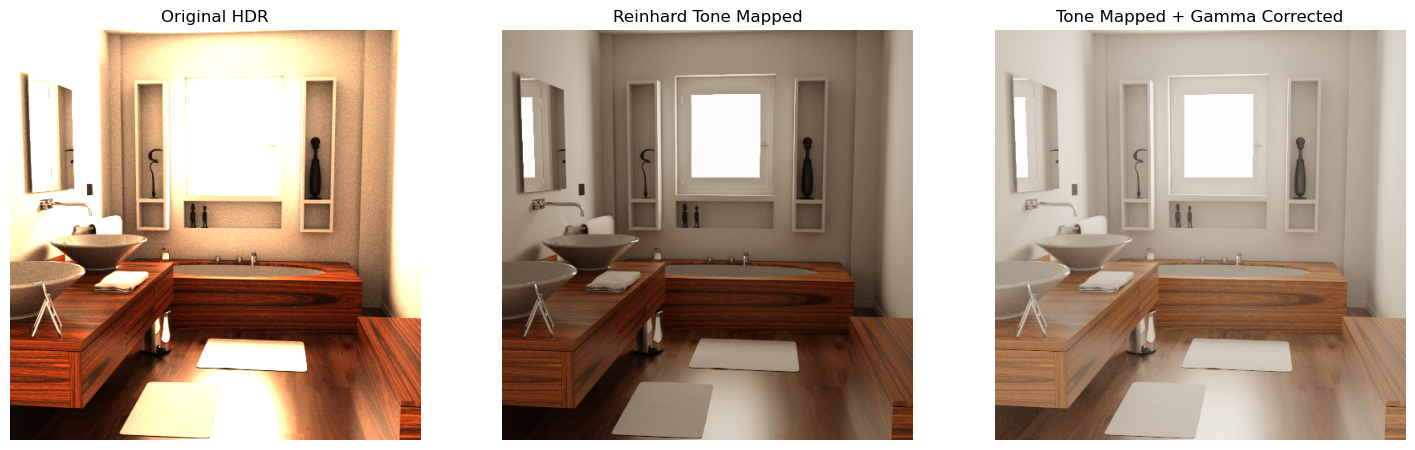

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

# Load HDR .tiff
img = tifffile.imread("../output/bathroom2/bathroom2_scene_spp4500.tiff").astype(np.float32)  # shape: (H, W, 3)

# Reinhard tone mapping
img_tone = img / (1.0 + img)

# Gamma correction for display
img_display = np.power(np.clip(img_tone, 0, 1), 1/2.2)

# For the original HDR image, normalize for display only (clipping won't be exact but for visualization)
img_orig_norm = img / (np.max(img) + 1e-8)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(img)
axs[0].set_title('Original HDR')
axs[0].axis('off')

axs[1].imshow(img_tone)
axs[1].set_title('Reinhard Tone Mapped')
axs[1].axis('off')

axs[2].imshow(img_display)
axs[2].set_title('Tone Mapped + Gamma Corrected')
axs[2].axis('off')

plt.show()

# Plot EXR files

In [1]:
import OpenEXR
import Imath
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

def load_exr_channels(filepath):
    file = OpenEXR.InputFile(filepath)
    header = file.header()
    
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    size = (height, width)

    channels = file.header()['channels'].keys()
    pixel_type = Imath.PixelType(Imath.PixelType.FLOAT)

    print(f"Found channels: {list(channels)}")
    print(f"Resolution: {width} x {height}\n")

    stats = {}
    images = {}

    for ch in channels:
        data = file.channel(ch, pixel_type)
        arr = np.frombuffer(data, dtype=np.float32).reshape(size)
        
        ch_stats = {
            'min': np.min(arr),
            'max': np.max(arr),
            'mean': np.mean(arr),
            'std': np.std(arr)
        }
        stats[ch] = ch_stats
        images[ch] = arr

        print(f"[{ch}] Min: {ch_stats['min']:.4f}  Max: {ch_stats['max']:.4f}  Mean: {ch_stats['mean']:.4f}  Std: {ch_stats['std']:.4f}")
    
    return stats, images

def plot_channels(images):
    channels = sorted(images.keys())
    num_channels = len(channels)

    plt.figure(figsize=(15, 5))
    
    for i, ch in enumerate(channels):
        plt.subplot(1, num_channels, i + 1)
        img = images[ch]
        
        # Normalize to [0, 1] for display
        norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
        plt.imshow(norm, cmap='gray')
        plt.title(f"Channel: {ch}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_rgb(images):
    if all(c in images for c in ['R', 'G', 'B']):
        rgb = np.stack([images['R'], images['G'], images['B']], axis=-1)
        norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
        plt.figure(figsize=(6, 6))
        plt.imshow(norm)
        plt.title("RGB Image")
        plt.axis('off')
        plt.show()

In [2]:
exr_path = Path("data/bathroom2/TungstenRender.exr")
# Load and analyze

In [ ]:
stats, images = load_exr_channels(exr_path)

: 

In [ ]:
plot_rgb(images)

In [ ]:
plot_channels(images)

# Model Analysis

In [7]:
import torch
state_dict = torch.load("../checkpoints/2025-07-25_noise2noise_mean_binsimg_reinhard_ep100_gpu.pth", map_location='cpu')

for key, value in state_dict.items():
    print(f"{key}: {value.shape}")

down_convs.0.conv1.weight: torch.Size([48, 3, 3, 3])
down_convs.0.conv1.bias: torch.Size([48])
down_convs.0.conv2.weight: torch.Size([48, 48, 3, 3])
down_convs.0.conv2.bias: torch.Size([48])
down_convs.0.conv3.weight: torch.Size([48, 48, 3, 3])
down_convs.0.conv3.bias: torch.Size([48])
down_convs.1.conv1.weight: torch.Size([96, 48, 3, 3])
down_convs.1.conv1.bias: torch.Size([96])
down_convs.1.conv2.weight: torch.Size([96, 96, 3, 3])
down_convs.1.conv2.bias: torch.Size([96])
down_convs.1.conv3.weight: torch.Size([96, 96, 3, 3])
down_convs.1.conv3.bias: torch.Size([96])
down_convs.2.conv1.weight: torch.Size([192, 96, 3, 3])
down_convs.2.conv1.bias: torch.Size([192])
down_convs.2.conv2.weight: torch.Size([192, 192, 3, 3])
down_convs.2.conv2.bias: torch.Size([192])
down_convs.2.conv3.weight: torch.Size([192, 192, 3, 3])
down_convs.2.conv3.bias: torch.Size([192])
down_convs.3.conv1.weight: torch.Size([384, 192, 3, 3])
down_convs.3.conv1.bias: torch.Size([384])
down_convs.3.conv2.weight: tor